

---



In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import nltk


1-Loading the data and Preprocessing

In [8]:
train_data= pd.read_csv('twitter_training.csv', header = None)
valid_data = pd.read_csv('twitter_validation.csv', header = None)

train_data.columns = ['ID', 'Category', 'Sentiment', 'Text']
valid_data.columns = ['ID', 'Category', 'Sentiment', 'Text']

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


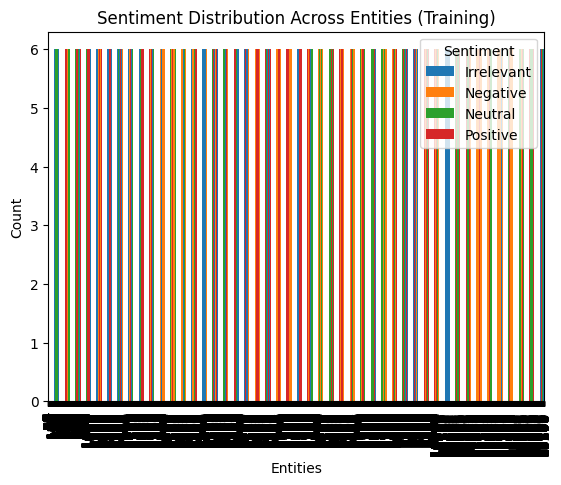

In [127]:
import matplotlib.pyplot as plt

# Calculate sentiment distribution
sentiment_distribution_train = train_data.groupby('ID')['Sentiment'].value_counts().unstack(fill_value=0)
sentiment_distribution_valid = valid_data.groupby('ID')['Sentiment'].value_counts().unstack(fill_value=0)

# Plot sentiment distribution
sentiment_distribution_train.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution Across Entities (Training)')
plt.xlabel('Entities')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

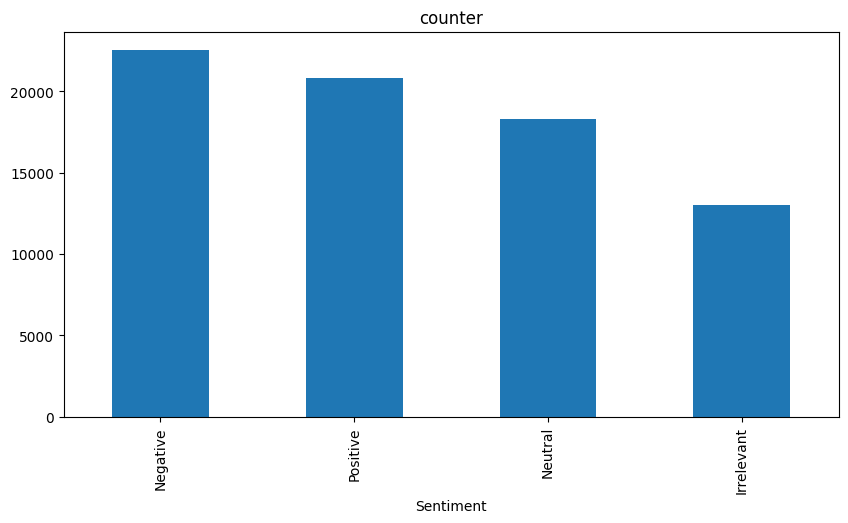

In [131]:
ax = train_data['Sentiment'].value_counts()\
     .plot(kind='bar',
           title = 'counter',
           figsize = (10,5))
ax.set_xlabel('Sentiment')
plt.show()


In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
def preprocess(text):

    text = str(text)
    text = re.sub(r'https?://\S+', '', text)# Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)# Remove special characters
    text = text.encode('ascii', 'ignore').decode('ascii')# Remove emojis
    text = text.lower()# Convert to lowercase

    tokens = word_tokenize(text)# Tokenize
    filtered_tokens = [word for word in tokens if word not in stop_words]  #remove stopwords
    return ' '.join(filtered_tokens)

In [27]:

train_data['clean_text'] = train_data['Text'].apply(preprocess)
valid_data['clean_text'] = valid_data['Text'].apply(preprocess)


In [105]:
label_encoder = LabelEncoder()
train_data['label_encoded'] = label_encoder.fit_transform(train_data['Sentiment'])
valid_data['label_encoded'] = label_encoder.transform(valid_data['Sentiment'])

In [31]:
train_data.head(100)

,ID,Category,Sentiment,Text,clean_text,label_encoded
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder,3
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,3
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,3
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,3
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder,3
...,...,...,...,...,...,...
95,2416,Borderlands,Neutral,I hate that this easy horrible modifier event ...,hate easy horrible modifier event game last fo...,2
96,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...,grounded almost looked pretty cool even despit...,1
97,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...,grounded looked cool despite borderline unfunn...,1
98,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t...",grosskreutz looked pretty cool even despite un...,1


2-Models and training

In [35]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_TF = tfidf_vectorizer.fit_transform(train_data['clean_text'])
X_valid_TF = tfidf_vectorizer.transform(valid_data['clean_text'])

In [63]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter = 50)
pac.fit(X_train_TF, train_data['Sentiment'])

PassiveAggressiveClassifier(max_iter=50)

Evaluation

In [65]:
from sklearn.metrics import accuracy_score
y_pred = pac.predict(X_valid_TF)
score = accuracy_score(valid_data['Sentiment'], y_pred)
print(f'Acc: {round(score*100, 2)}%')

Acc: 95.2%


In [37]:
#Roberta model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [82]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  sentiments = output[0][0].detach().numpy()
  sentiments = softmax(sentiments)
  sentiments_dict = {

    'roberta_pos':sentiments[0],
    'roberta_neu':sentiments[1],
    'roberta_neg':sentiments[2]

  }
  return sentiments_dict

In [83]:
from tqdm.notebook import tqdm
res = {}
counter=0
for i, row in tqdm(train_data.iterrows(), total=1000):
  text = row['Text']
  myid = row['ID']
  if not isinstance(text, str):
    text = str(text)
  res[myid] = polarity_scores_roberta(text)
  counter+=1
  if counter == 1000:
     break


  0%|          | 0/1000 [00:00<?, ?it/s]

In [123]:
robertas = pd.DataFrame(res).T
robertas = robertas.reset_index().rename(columns={'index' : 'ID'})
robertas = robertas.merge(train_data, how = 'left')

In [124]:
robertas.head()

,ID,roberta_pos,roberta_neu,roberta_neg,Category,Sentiment,Text,clean_text,label_encoded
0,2401,0.778829,0.196587,0.024584,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder,0.0
1,2401,0.778829,0.196587,0.024584,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,0.0
2,2401,0.778829,0.196587,0.024584,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,0.0
3,2401,0.778829,0.196587,0.024584,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,0.0
4,2401,0.778829,0.196587,0.024584,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder,0.0



Bag-of-Words model

In [39]:
# Bag-of-Words model
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(train_data['clean_text'])
X_valid_bow = bow_vectorizer.transform(valid_data['clean_text'])

Evaluation

In [66]:
pac = PassiveAggressiveClassifier(max_iter = 50)
pac.fit(X_train_bow, train_data['Sentiment'])

y_pred_bow = pac.predict(X_valid_TF)
score = accuracy_score(valid_data['Sentiment'], y_pred_bow)
print(f'Acc: {round(score*100, 2)}%')

Acc: 92.9%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


VADER (USE BoW)

In [ ]:
# Download the vader_lexicon resource
!python -m nltk.downloader vader_lexicon

# Import the necessary modules
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Create an instance of the SentimentIntensityAnalyzer class
sia = SentimentIntensityAnalyzer()

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
res = {}
for i, row in tqdm(train.iterrows(), total=len(train)):
  text = row['Text']
  myid = row['ID']
  if not isinstance(text, str):
    text = str(text)
  res[myid] = sia.polarity_scores(text)

  0%|          | 0/74682 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index' : 'ID'})
vaders = vaders.merge(train, how = 'left')

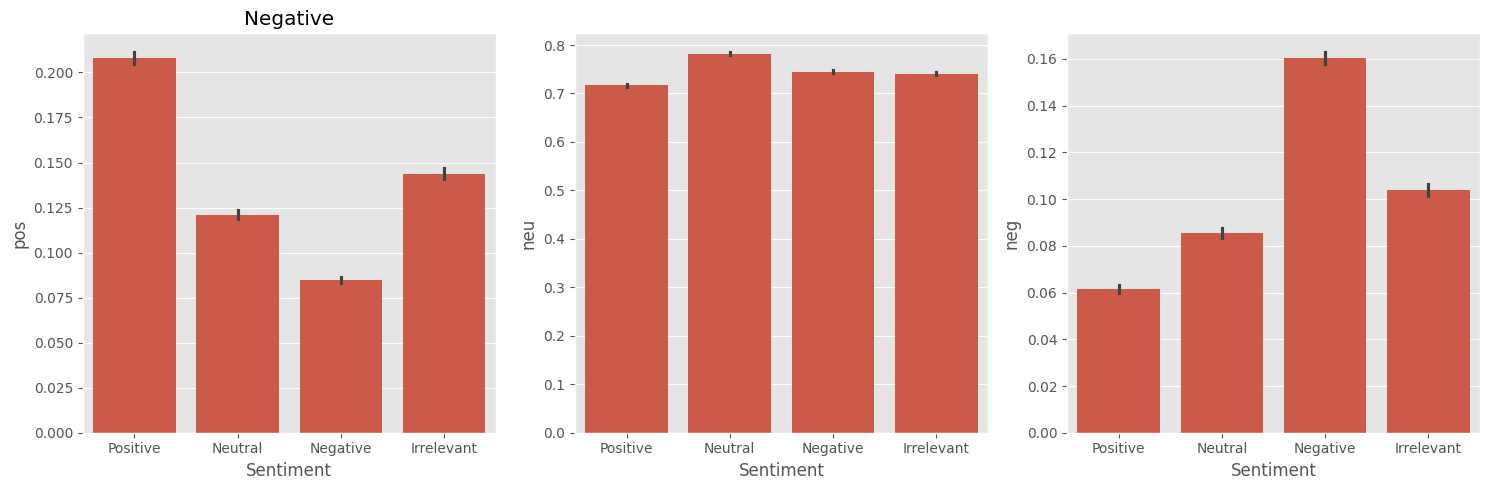

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data = vaders, x='Sentiment', y='pos',ax= axs[0])
sns.barplot(data = vaders, x='Sentiment', y='neu',ax= axs[1])
sns.barplot(data = vaders, x='Sentiment', y='neg',ax= axs[2])
axs[0].set_title('Positive')
axs[0].set_title('Netural')
axs[0].set_title('Negative')
plt.tight_layout()
plt.show()

In [129]:
#Challenges encountered during the project (e.g., imbalanced data, noisy text, model complexity).
#Recommendations for improving model performance (e.g., data augmentation, hyperparameter tuning, ensemble methods).
#uggestions for future iterations of the sentiment analysis project (e.g., incorporating domain-specific knowledge, exploring advanced NLP techniques).